# Project I | Deep Learning: Image Classification with CNN

# Part 1
- To build a Convolutional Neural Network (CNN) model to classify images from the Animals10 dataset.

1. Data Loading
- Load the dataset (e.g., from folders or URLs)
- Split into train/validation/test sets

2. Preprocessing
- Resize images, normalize pixel values, and apply augmentations (flip, rotate, etc.)

3. Visualization
- Show sample images with labels using matplotlib


# 1. Imports and GPU Setup

In [64]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# 2. Data Loading and Preprocessing

In [65]:
# Path to your dataset
dataset_path = '../../data/animals10/'

# Define transformations: Resize, Augment, Convert to Tensor, Normalize
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load dataset
dataset = ImageFolder(root=dataset_path, transform=transform)

# Split dataset (80% training, 20% validation)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Wrap in DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Total images: {len(dataset)}")
print(f"Training set: {len(train_dataset)}")
print(f"Validation set: {len(val_dataset)}")


Total images: 26179
Training set: 20944
Validation set: 5235


# 3. Visualize Sample Images

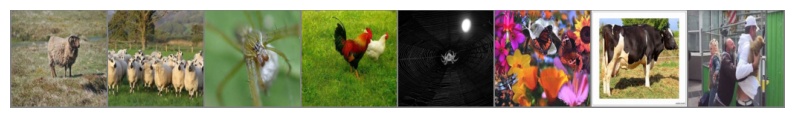

Labels: ['pecora', 'pecora', 'ragno', 'gallina', 'ragno', 'farfalla', 'mucca', 'cane']


In [66]:
# Helper to show image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize from [-1,1] to [0,1]
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images with labels
imshow(torchvision.utils.make_grid(images[:8]))
print('Labels:', [dataset.classes[label] for label in labels[:8]])


# 📘 Part 2

Goal:
- A CNN built from scratch using PyTorch

Include:
- Convolutional Layers
- Pooling Layers
- Fully Connected (Linear) Layers

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AnimalCNN(nn.Module):
    def __init__(self, num_classes):
        super(AnimalCNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.flatten = nn.Flatten()

        # Input size after 3 pools on 128x128: 128 → 64 → 32 → 16
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Model Initialization & Summary

In [68]:
num_classes = len(dataset.classes)
model = AnimalCNN(num_classes=num_classes) 
model.to(device)
print(model)


AnimalCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


# 🧠 Part 3

- Train the CNN using SGD and Adam, will pick the best one.
- Use a loss function
- Track accuracy and loss
- Add early stopping to prevent overfitting

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training settings
num_epochs = 100
patience = 3  # Early stopping patience
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # ---- Training ----
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)

    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

    # ---- Validation ----
    model.eval()
    val_running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)


    print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # ---- Early Stopping ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "../data/best_model_lg.pth")
        print("YES!!! Model improved. Saving model.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f" :-( No improvement. Early stop counter: {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print(" Enought!! Early stopping triggered.")
        break

# ---- Plot Loss Curves ----
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()



Epoch 1/100


100%|██████████| 655/655 [00:39<00:00, 16.61it/s]


Train Loss: 1.6258, Accuracy: 0.4330
Val Loss: 1.3179, Accuracy: 0.5542


RuntimeError: Parent directory ../data does not exist.

- Training Loss: How well the model is doing on the training data (the data it sees during learning).
- Validation Loss: How well the model is doing on unseen data.
- Ideal Scenario: Low training and validation loss that stay close to each other.

If:
- Training loss ↓ but validation loss ↑ → model is overfitting
- Both losses ↓ together → you're doing well ✅